In [1]:
pip install -U sentence-transformers


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
print(embeddings.size)


C:\Users\konrad_master\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


768


C:\Users\konrad_master\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [3]:
import zipfile
import pandas as pd
import chardet

# Path to the zip file
zip_file_path = '../archive.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    # List all the files in the ZIP archive
    file_names = zip_file.namelist()
    print(f"Files in the ZIP: {file_names}")

    # Assume there's only one CSV file or you know its name
    csv_file_name = file_names[0]  # Adjust if needed

    # Read the CSV file into a pandas DataFrame
    with zip_file.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file, encoding='Windows-1252')

# Display the DataFrame
print(df['v2'])

Files in the ZIP: ['spam.csv']
0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object


In [4]:
from datasets import load_dataset

#ds = load_dataset("wikimedia/wikipedia", "20231101.en")
dataset = load_dataset("Salesforce/wikitext", "wikitext-103-v1", cache_dir=".checkpoints/data")

In [5]:
print(dataset['train'])

Dataset({
    features: ['text'],
    num_rows: 1801350
})


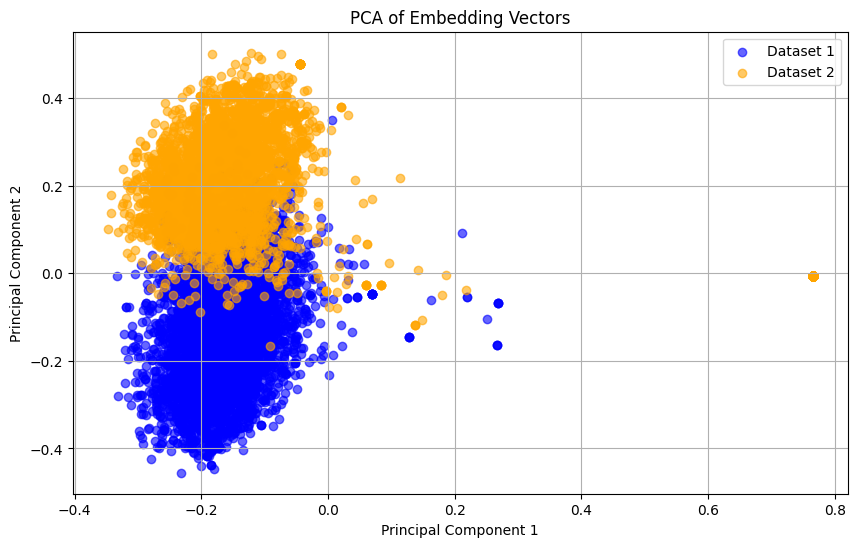

In [7]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

text_data_1 = df['v2'].dropna().sample(5000, random_state=42).tolist()

# Extract 500 samples from the train split
text_data_2 = dataset['train']['text'][:5000]

# Step 3: Convert text data to embeddings (using the preloaded model)
sentences_1 = text_data_1
sentences_2 = text_data_2

# Generate embeddings
embeddings_1 = model.encode(sentences_1)
embeddings_2 = model.encode(sentences_2)

# Combine embeddings and labels


labels_1 = np.zeros(len(embeddings_1))  # Label 0 for dataset_1
labels_2 = np.ones(len(embeddings_2))   # Label 1 for dataset_2

embeddings = np.vstack((embeddings_1, embeddings_2))
labels = np.hstack((labels_1, labels_2))

# Step 4: Perform PCA


pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Step 5: Visualize the embeddings


plt.figure(figsize=(10, 6))
plt.scatter(embeddings_pca[labels == 0, 0], embeddings_pca[labels == 0, 1], label='Dataset 1', alpha=0.6, color='blue')
plt.scatter(embeddings_pca[labels == 1, 0], embeddings_pca[labels == 1, 1], label='Dataset 2', alpha=0.6, color='orange')
plt.title("PCA of Embedding Vectors")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
pip install psycopg2


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.2 MB ? eta -:--:--
   --------------------------- ------------ 0.8/1.2 MB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 2.4 MB/s eta 0:00:00


In [10]:
print(embeddings_1[0].size)

384


In [13]:
import psycopg2
from psycopg2.extras import execute_batch

# Database connection details
DB_CONFIG = {
    "dbname": "vectorDBTest",
    "user": "postgres",
    "password": "Skill",
    "host": "localhost",  # or your database host
    "port": 5432          # default PostgreSQL port
}

# Step 1: Connect to the database
conn = psycopg2.connect(**DB_CONFIG)
cursor = conn.cursor()

cursor.execute("CREATE EXTENSION IF NOT EXISTS vector;")

# Step 2: Create the table with a vector and binary label
cursor.execute("""
    CREATE TABLE IF NOT EXISTS embeddings (
        id SERIAL PRIMARY KEY,
        vector VECTOR(384), -- Adjust the dimension (3 in this example)
        label BOOLEAN
    );
""")

cursor.execute("""
        CREATE INDEX IF NOT EXISTS embeddings_vector_idx 
        ON text_embeddings USING ivfflat (embedding) 
        WITH (lists = 100);
    """)

conn.commit()

data_to_insert = [(list(embedding), bool(label)) for embedding, label in zip(embeddings, labels)]

insert_query = """
        INSERT INTO embeddings (embedding, label) 
        VALUES (%s, %s);
    """
execute_batch(cursor, insert_query, data_to_insert)
conn.commit()

print(f"Inserted {len(data_to_insert)} embeddings into the database.")

    # Close the connection
cursor.close()
conn.close()


FeatureNotSupported: FEHLER:  Erweiterung »vector« ist nicht verfügbar
DETAIL:  Konnte Erweiterungskontrolldatei »C:/Program Files/PostgreSQL/16/share/extension/vector.control« nicht öffnen: No such file or directory.
HINT:  Die Erweiterung muss zuerst auf dem System, auf dem PostgreSQL läuft, installiert werden.
